In [101]:
import numpy as np
from PIL import Image, ImageDraw #Подключим необходимые библиотеки.
import matplotlib.pyplot as plt
#import Tkinter as tk
from PIL import ImageTk

Градиент это плавный переход от цвета к цвету.

In [102]:
img = Image.open("temp.jpg") #Открываем изображение. 
draw = ImageDraw.Draw(img) #Создаем инструмент для рисования. 
width = img.size[0] #Определяем ширину. 
height = img.size[1] #Определяем высоту.
pix = img.load() #Выгружаем значения пикселей.

min_x и min_y минимальные размеры интересующих нас областей (если это не указывать, будет выведено огромное количество прямоугольных градиентов). prox указвает допустимую разницу в RGB соседних пикселей. При ее уменьшении будем получать градиентные области меньше из-за большей чувствителбности к разнице между цветами в переходе градиента.

In [103]:
min_x = 20
min_y = 30
prox = 20

Будем обрабатывать данную картинку

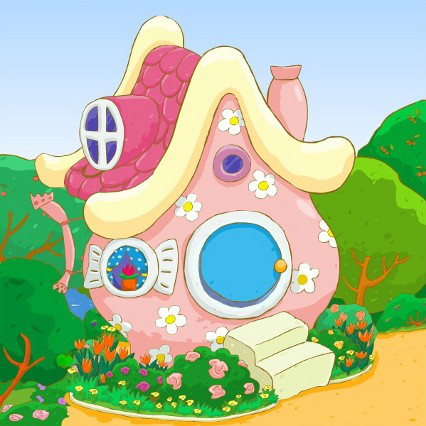

In [104]:
img

Приведем ее к numpy массиву

In [105]:
image = np.array(img) 

In [106]:
image

array([[[180, 218, 254],
        [180, 218, 254],
        [180, 218, 254],
        ...,
        [181, 217, 249],
        [182, 217, 247],
        [182, 217, 247]],

       [[180, 218, 254],
        [180, 218, 254],
        [180, 218, 254],
        ...,
        [181, 217, 249],
        [184, 219, 249],
        [184, 219, 249]],

       [[180, 218, 254],
        [180, 218, 254],
        [180, 218, 254],
        ...,
        [181, 217, 249],
        [183, 218, 250],
        [183, 218, 248]],

       ...,

       [[ 15, 147,  37],
        [ 21, 149,  40],
        [ 28, 149,  43],
        ...,
        [255, 207, 107],
        [252, 204, 106],
        [250, 204, 108]],

       [[ 24, 156,  44],
        [ 22, 150,  37],
        [ 27, 149,  38],
        ...,
        [253, 205, 105],
        [253, 205, 107],
        [251, 205, 109]],

       [[ 24, 157,  40],
        [ 22, 151,  35],
        [ 27, 150,  36],
        ...,
        [253, 205, 103],
        [251, 203, 103],
        [249, 203, 105]]

In [107]:
image.shape

(426, 426, 3)

426 и 347 это размер самой картинки в пикселях, а последнее число 3 означает 3 числа, отвечающие за цвет (RGB) 

Напишем функцию, которая будет искать левого и верхнего соседа для каждого пикселя 

In [108]:
def left_up_neighbours (i, j):
    if i == 0:
        if j == 0:
            return []
        elif j == height - 1:
            return [[0, height - 2]]
        else:
            return [[i, j - 1]]
    elif i == width - 1:
        if j == 0:
            return [[width - 2, 0]]
        elif j == height - 1:
            return [[width - 1, height - 2], [width - 2, height - 1]]
        else:
            return [[i - 1, j], [i, j - 1]]
    elif j == 0:
        return [[i - 1, j]]
    elif j == height - 1:
        return [[i - 1, j], [i, j - 1]]
    else:
        return [[i - 1, j], [i, j - 1]]

Создадим двумерный numpy массив такого же размера как и картинка, в котором будет стоять 0 если соответсвующий пиксель входит в какую-либо градиентную область (разница каждого из составляющих RGB для соседних пикселей меньше дибо равна prox, которую мы установили ранее

In [109]:
grad = np.zeros((width, height))
for i in range(width):
    for j in range(height):
        nei = left_up_neighbours(i, j)
        passes = True
        for k in nei:
            for c in range(3):
                if abs(int(image[k[1]][k[0]][c]) - int(image[j][i][c])) > prox:
                    passes = False
        if not passes:
            grad[i][j] = 1

Для более наглядного вида преобразуем получившийся массив в картинку, в которой все нули заменим на черные пиксели, а единицы на белые. Тогда в итоге получится картинка с черными градиентными областями, разделенными между собой белыми линиями

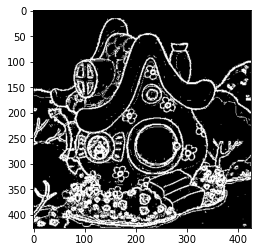

In [110]:
for i in range(width):
    for j in range(height):
        if grad[i][j] == 0:
            image[j][i] = [0, 0, 0]
        else:
            image[j][i] = [255, 255, 255]
plt.imshow(image)

Сопоставляя картинки, видим, что prox=20 дает довольно точный вид градиентных областей

Сохранил картинку для более детального сравнения контуров.

In [111]:
im = Image.fromarray(image)
im.save("your_file.jpeg")

Самый наивный алгоритм поиска нулевых прямоугольников в матрице, состоящих из нулей и единиц представляет собой поиск для каждой ячейки максимально длинного фрагмента только из нулей с заданной тольщиной. Меняя соответсвенно тольщину куска, который мы ищем, получим для каждой вершины набор всевозможных прямоугольных областей, дальше можно наложить ограничение на площадь, чтобы уменьшить количество найденных областей. Ассимптотика данного алгоритма равна $O(n^2m^2)$.

In [ ]:
ans = []
for i in range(width):
    for j in range(height):
        
        for high in range(j, height):
            for wide in range(i, width):
                if grad[wide][high] == 1:
                    break
            if (wide - i + 1) * (high - j + 1) > 50000:
                ans.append([i, j, wide, high])

In [ ]:
ans

Более быстрый алгоритм, который работает за $O(nm)$ выглядит так. Функция solver находит максимальную градиентную область и меняет все нули в этой области в массиве grad на единицы, тем самым вырезая его. Повторяем эти итерации, тем самым по очереди убираем самые больие градиентные области.

In [112]:
def solver(a, n, m, restrict=None):
    ans = 0
 
    d = [-1] * m
    d1 = [0] * m 
    d2 = [0] * m
    
    A = None
    B = None
 
    st = list()
 
    for i in range(n):
        for j in range(m):
            if a[i][j] == 1:
                d[j] = i
 
    while len(st): 
        st.pop()
 
    for j in range(m):
        while len(st) > 0 and d[st[len(st) - 1]] <= d[j]:  
            st.pop()
 
        d1[j] = -1 if len(st) == 0 else st[len(st) - 1]
        st.append(j)
 
    while len(st): 
        st.pop()
 
    for j in range(m - 1, -1, -1):
        while len(st) and d[st[len(st) - 1]] <= d[j]:
            st.pop()
        d2[j] = m if len(st) == 0 else st[len(st) - 1]
        st.append(j)
 
    for j in range(m):
        area = (i - d[j]) * (d2[j] - d1[j] - 1)
        if area > ans:
            A = (d[j] + 1, d1[j]+1)
            B = (i, d2[j]-1)
            ans = area

    return (ans, A, B)

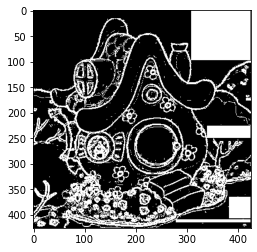

In [121]:
while
i = solver(grad, width, height)
for hi in range(i[1][0], i[2][0]):
    for wi in range(i[1][1], i[2][1]):
        grad[hi][wi] = 1

im = Image.fromarray(image)
im.save("your_file.jpeg")

for i in range(width):
    for j in range(height):
        if grad[i][j] == 0:
            image[j][i] = [0, 0, 0]
        else:
            image[j][i] = [255, 255, 255]
plt.imshow(image)

In [115]:
im = Image.fromarray(image)
im.save("your_file.jpeg")

In [116]:
draw = ImageDraw.Draw(im)
for i in regions:
    draw.rectangle(((i[1], i[2])), fill='red')
im.show()

TypeError: 'int' object is not subscriptable